# Final Product

In this notebook we will develope the final product of the project: a tool that staff in emergency departments could use to quickly determine medical urgency. We will look at the most influential factors from the logistic regression model that used the 'l1' penalty function to guide us as to which features to use in the tool. Then we will explore logistic regression and XGBoost as possible modelling options to use int he final product, since they were the best performing models on the whole pre processed dataset. 

We start by importing relevant packages and loading in the data.

In [51]:
# importing relevant packages

# generic
import numpy as np
import pandas as pd

# for training models 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# pickling models
import joblib

# finding best model
from sklearn.model_selection import GridSearchCV, cross_val_score

# plots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# packages for model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [6]:
# loading the data
df = pd.read_parquet('../data/cleaned/dataCleanWMedicalUrgency.parquet')

# saetting y to be the target variable
y = df['medical_urgency']

# importing the preprocessed data
X = pd.read_parquet('../data/cleaned/featuresPreprocessed.parquet')

# splitting the data
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.25, random_state=1234, stratify=y)

# resetting indices to allow models to run properly
X_rem.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_rem.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

Now let's load in the logistic regression model with the 'l1' penalty function from notebook '04-modelling'. 

In [4]:
# loading the optimised model
gridsearch_log_reg = joblib.load('../model/logistic_model_3_gridsearch_rem.pkl')

Now we get the factors in order of their influence to predicting class 0. We are most interested in predicting class 0 as it is the most critical condition and accurately predicting these cases will have the biggest effect on lives saved.

In [62]:
# setting up a series of the most influential factors
most_inf = pd.DataFrame(gridsearch_log_reg.best_estimator_['log_reg'].coef_, columns = X_exp.columns).iloc[0, :].sort_values(ascending=False)

Let's have a look at the most positively influential factors and the most negatively influential factors.

In [66]:
# getting the top 30 positively influential factors
most_inf.head(30)

cc_suicidal                  0.590738
cc_alcoholintoxication       0.545969
cc_strokealert               0.379917
cc_psychiatricevaluation     0.363111
cc_chestpain                 0.357229
age                          0.330140
cc_alteredmentalstatus       0.297843
cc_modifiedtrauma            0.265487
cc_fulltrauma                0.252393
cc_shortnessofbreath         0.241053
cc_cardiacarrest             0.232347
cc_drugproblem               0.203411
cc_unresponsive              0.191965
cc_neurologicproblem         0.182020
cc_alcoholproblem            0.175046
cc_overdose-intentional      0.170798
cc_syncope                   0.160671
cc_poisoning                 0.151483
cc_other                     0.148689
cc_gibleeding                0.130433
cc_depression                0.129846
cc_sicklecellpain            0.129612
cc_drug/alcoholassessment    0.128323
cc_psychoticsymptoms         0.125765
cc_bodyfluidexposure         0.122807
n_admissions                 0.120508
cc_homicidal

In [64]:
# getting the top 30 negatively influential factors
most_inf.tail(30)

cc_woundcheck             -0.107496
cc_wristpain              -0.108750
cc_footinjury             -0.108773
cc_skinirritation         -0.110097
cc_toepain                -0.110937
cc_coldlikesymptoms       -0.111721
cc_motorvehiclecrash      -0.112664
cc_ankleinjury            -0.114769
previousdispo_Discharge   -0.116514
cc_cyst                   -0.117839
cc_abdominalpain          -0.121905
cc_fingerinjury           -0.126104
cc_cough                  -0.133137
cc_fingerpain             -0.134178
cc_laceration             -0.136546
cc_handpain               -0.138234
cc_anklepain              -0.157560
cc_legpain                -0.166202
cc_abscess                -0.167325
cc_footpain               -0.175424
cc_sorethroat             -0.184857
cc_earpain                -0.185385
cc_rash                   -0.194001
cc_dentalpain             -0.206503
cc_suture/stapleremoval   -0.211562
cc_kneepain               -0.240337
cc_backpain               -0.244013
dep_name_B                -0

It looks like they are almost exclusively chief complaints. This isn't very surprising since 'esi' score is calculated using these factors. 

We can see that age is fairly influential, as well as department name and arrival_mide_Unknown (though it's worth noting that these are when compared to department A and arrival_mode_car - from notebook '03-pre-processing'). 

Our product will be a model that uses all the chief complaint factors, as well as dep_name_B, dep_name_C, age, and 'arrivalmode_Unknown'. The chief complaints can be set to 0 as default and anny staff member could tick the complaints that apply to the patient, which wouldn't take longer than assesing them, which they would be doing anyway. The other factors we have decided to include are easily accessible (even age could be roughly guessed if the pateient cannot tell them their age - though in this case theyd probably be in class 0 anyway......). 

We havent included some of the other influential factors such as 'previousdispo_Discharge' since it may be harder information to access, and they aren't very influential anyway. 

Let's make the dataset for the product.

In [22]:
# creating the production dataset, 'X_prod'
X_prod = X.loc[:, 'cc_abdominalcramping' : 'cc_wristpain']
X_prod['age'] = X['age']
X_prod['dep_name_B'] = X['dep_name_B']
X_prod['dep_name_C'] = X['dep_name_C']
X_prod['arrivalmode_Unknown'] = X['arrivalmode_Unknown']

Now we need to split the data as before so that we have the same test set. 

In [ ]:
# splitting the porduction data
X_prod_rem, X_prod_test, y_rem, y_test = train_test_split(X_prod, y, test_size=0.25, random_state=1234, stratify=y)

Let's have a quick look to see how many chief complaints we can have per patient. We are doing this as, if each patient is only ever givemn one chief complaint, we can get rid of one as it will be determined by the others. 

In [49]:
X.loc[:, 'cc_abdominalcramping' : 'cc_wristpain'].sum(axis=1).value_counts()

1.0    487658
2.0     59668
3.0      7101
4.0       850
5.0       120
6.0        17
7.0         3
Name: count, dtype: int64

We can have up to 7 cheif complaints per patient, so we will leave all chief complaints in the production dataset.

Now let's have a look at any colinearity in the production dataset, which could affect our models.

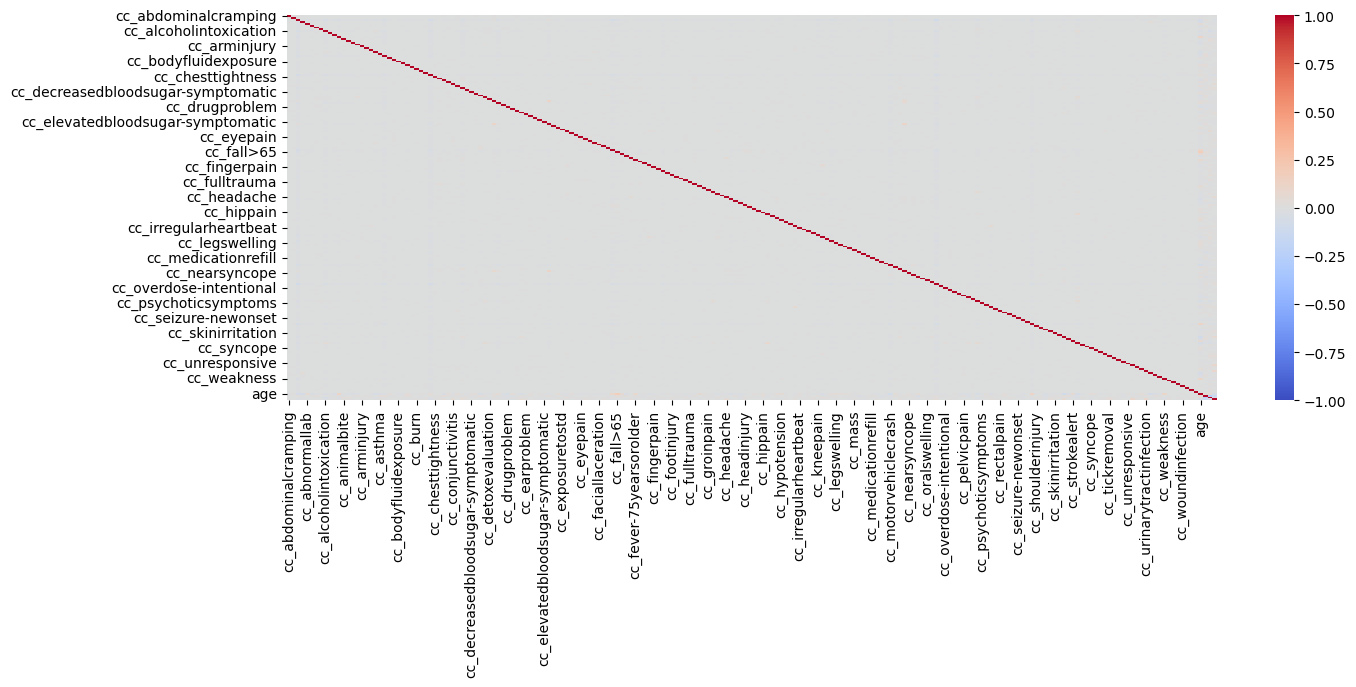

In [54]:
# plotting a heatmap of correlations between feature variables in the production dataset
plt.figure(figsize=(15, 5))
sns.heatmap(X_prod.corr(), cmap="coolwarm", vmax=1.0, vmin=-1.0)
plt.show()

This isn't very readable, but it is quite clear that the only significant correlations are between a feature and itself (on the diagonal), so we won't get rid of any feature variable. 

We are ready to move onto choosing a suitable model. 

## Logistic Regression

Let's start with a logistic regression. 

We will set up a pipeline to perform a gridsearch on to optimise the model. We will optimise over penalty constant, 'C', and penalty function. 

In [41]:
# setting up the estimators 
estimators = [
    ('normalise', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=10000, solver='liblinear'))
]
pipe = Pipeline(estimators)

# setting upi values for the 'C' parameter
C = [0.01, 0.1, 1, 10]
penalties = ['l1', 'l2']

# setting up the parameters of the girdsearch
params = dict(
    log_reg__C = C,
    log_reg__penalty = penalties
)

Now let's set up the gridsearch.

In [55]:
# setting up the grid search model 
gridsearch_model_log_reg_prod = GridSearchCV(pipe, param_grid=params, cv=5)

# fitting the girsearch
gridsearch_model_log_reg_prod.fit(X_prod_rem, y_rem)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('normalise', StandardScaler()),
                                       ('log_reg',
                                        LogisticRegression(max_iter=10000,
                                                           solver='liblinear'))]),
             param_grid={'log_reg__C': [0.01, 0.1, 1, 10],
                         'log_reg__penalty': ['l1', 'l2']})

Now we pickle the optimal model for later use.

In [57]:
# saving the gridsearch
joblib.dump(gridsearch_model_log_reg_prod, '../model/logistic_model_prod.pkl')

['../model/logistic_model_prod.pkl']

In [58]:
# loading the production logistic regression model
log_reg_model_prod = joblib.load('../model/logistic_model_prod.pkl')

Let's see what the best parameters were.

In [59]:
log_reg_model_prod.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('log_reg',
                 LogisticRegression(C=10, max_iter=10000, penalty='l1',
                                    solver='liblinear'))])

C = 10 and penalty function 'l1' were optimal from the optiomns we tested. This is interesting: it implies that the best model gets rid of as many factors as possible and just uses a few core factors in prediction, and that many of the cheif complaints aren't useful in predicting medical urgency score. 

Now let's have a look at the accuracy. 

In [60]:
# seeing the accuracy score of the model
log_reg_model_prod.score(X_prod_test, y_test)

0.7159915019264701

The model has an accuracy of 71.60%. This is not too much less than the best model using all the preprocessed features! Let's have a look at the classification report.

In [61]:
# getting the predicted values
y_pred_LR = log_reg_model_prod.predict(X_prod_test)

# making the classifiaction report
class_report_LR = classification_report(y_test, y_pred_LR)

# printing the classification report
print(class_report_LR)                               

              precision    recall  f1-score   support

           0       0.73      0.69      0.71     42006
           1       0.68      0.69      0.69     58779
           2       0.75      0.79      0.77     38070

    accuracy                           0.72    138855
   macro avg       0.72      0.72      0.72    138855
weighted avg       0.72      0.72      0.72    138855



These scores are pretty good, and most importantly we have the same class 0 recall as with the logistic regression model that used all the features. The other scores are a bit lower, but not much. 

Before we dive into details and evaluation, let's see if we can do any better with XGBoost. 

## XGBoost

Let's make the model and fit it to the production data.

In [68]:
# fitting a scaler 
scaler = StandardScaler()
scaler.fit_transform(X_prod_rem)
scaler.transform(X_prod_test)

# making the model 
xgboost_model = XGBClassifier()
xgboost_model.fit(X_prod_rem, y_rem)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Let's save the model for future use.

In [ ]:
joblib.dump(xgboost_model, '../model/xgboost_model_prod.pkl')

['../model/xgboost_model_prod.pkl']

Now we load the model in.

In [70]:
xgboost_model = joblib.load('../model/xgboost_model_prod.pkl')

Now we have a look at the accuracy score. 

In [71]:
# finding the accuracy score
xgboost_model.score(X_prod_test, y_test)

0.7236685751323323

The XGBoost model has an accuracy of 72.37%. This is a little bit better than the logistic regression, but only by less than 1%. This is marginal and we will have to have a look at the classification model before making a decision as to which to use for our final product.

Let's get the classification report.

In [40]:
# finding the predicted values
y_pred_XGB = xgb_model_prod.predict(X_prod_test)

# getting the classification report
class_report_XGB = classification_report(y_test, y_pred_XGB)

# printing the classification report
print(class_report_XGB)    

              precision    recall  f1-score   support

           0       0.75      0.66      0.71     42006
           1       0.68      0.73      0.70     58779
           2       0.76      0.78      0.77     38070

    accuracy                           0.72    138855
   macro avg       0.73      0.72      0.73    138855
weighted avg       0.73      0.72      0.72    138855



The scores are largely very similar. All scores for class 2 are basically the same. The most significant difference between the two models is the class 0 recall, which is 0.03 better in the logistic regression model. Given that this is the most important score alongside accuracy, and the difference in accuracy is marginal, we will use the logistic regression in our final product. 

# Evaluation

Is 69% an acceptable score for class 0 recall? Ultimately no. In an emergency department where hundreds of patients are coming in each day, we cannot afford to miss 31% of class 0 patients. So is the final model useless? Also no. The model will be intended to use alongside human judgement as an extra tool. 